<a href="https://colab.research.google.com/github/fhaarn/capres-sna-on-x/blob/main/capres_sna_oop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import random
import networkx as nx
import re
import matplotlib.pyplot as plt

#Class & Random Node Generator
deklarasi class dan generate node dari reply, retweet dan quote

In [2]:
nama_1 = ['Pandu', 'Gusti', 'Munikasari', 'Izhar', 'Bagir', 'Deka', 'Satria', 'Fitra', 'Deristya', 'Hidayatullah', 'Maruto', 'Hizrian', 'Riyadie', 'Zulfi', 'Ruslian', 'Fikri', 'Riany', 'Fahdnul', 'Listyani', 'Geraldi', 'Cansan', 'Deristya', 'Lendy', 'Usra']
nama_2 = ['Gusti', 'Bagir', 'Satria', 'Deristya', 'Hizrian', 'Ruslian', 'Riany', 'Listyani', 'Cansan', 'Lendy', 'Haq', 'Risyad', 'Oktaviani', 'Resa', 'Sunanto', 'Rahardianto', 'Husnah', 'Amaliya', 'Priatni', 'Fauzunuria', 'Anwisa', 'Pradana', 'Wahyuningtias', 'Apriyani', 'Simorangkir', 'Varensia', 'Ashim', 'Ihatrayudha', 'Tursia', 'Ulfania', 'Apriyanto', 'Destrya', 'Fiona', 'Tabriiz', 'Tobing', 'Umaeroh', 'Atarita', 'Kama', 'Husein', 'Dyarini', 'Falah', 'Noviana', 'Sasna', 'Widyasmoro', 'Pamungkas', 'Shabrina', 'Rohani', 'Prayoga', 'Arieska', 'Erditya', 'Sunday', 'Ersyahputra', 'Syabantika', 'Wahyudi', 'Nurfitria', 'Hidayat', 'Nisrina', 'Anggraini', 'Jaelani', 'Maulidah']
nama_array = nama_1 + nama_2

In [3]:
def generate_username(array_nama):
    # Menentukan panjang nama antara 2 dan 3 kata
    panjang_nama = random.randint(2, 3)

    # Memilih nama secara acak dari array_nama
    nama_acak = random.sample(array_nama, panjang_nama)

    # Menggabungkan nama menjadi satu string tanpa spasi
    nama_lengkap = ''.join(nama_acak)

    if random.choice([True, False]):
        angka = random.randint(1, 100)
        nama_lengkap += str(angka)

    return nama_lengkap

In [17]:
class TwitterGraph:
    def __init__(self, data):
        self.df = pd.DataFrame(data)
        self.G = nx.DiGraph()

    def drop_unused_features(self):
        # Drop unused features
        unused_features = set(self.df.columns) - {'username', 'full_text', 'reply_count', 'retweet_count', 'quote_count', 'mention_list','feature_indegree'}
        self.df.drop(columns=unused_features, inplace=True)

    def add_nodes_and_edges(self):
        for _, row in self.df.iterrows():
            for mention_user in row['mention_list']:
                self.G.add_edge(row['username'], mention_user)

    def generate_new_data(self):
        new_data = []
        for _, row in self.df.iterrows():
            feature_indegree = row['feature_indegree']
            for i in range(feature_indegree):
                new_data.append({
                    'username': generate_username(nama_array),
                    'full_text': '',
                    'reply_count': 0,
                    'retweet_count': 0,
                    'quote_count': 0,
                    'feature_indegree': 0,
                    'mention_list': [row['username']]
                })
        return new_data

    def add_new_data_to_dataframe(self, new_data):
        self.df = pd.concat([self.df, pd.DataFrame(new_data)], ignore_index=True)

    def calculate_feature_indegree(self):
        self.df['feature_indegree'] = self.df.apply(lambda row: row['reply_count'] + row['retweet_count'] + row['quote_count'], axis=1)

    def extract_mention_list_from_text(self):
        self.df['mention_list'] = self.df['full_text'].apply(lambda x: re.findall(r'@(\w+)', str(x)))

    def calculate_centralities(self):
        betweenness_centrality = nx.betweenness_centrality(self.G)
        in_degree_centrality = nx.in_degree_centrality(self.G)
        out_degree_centrality = nx.out_degree_centrality(self.G)
        degree_centrality = nx.degree_centrality(self.G)
        closeness_centrality = nx.closeness_centrality(self.G)
        eigenvector_centrality = nx.eigenvector_centrality(self.G, max_iter=500)

        #Raw degree
        n_minus_1 = len(self.G.nodes) - 1
        raw_degree_centrality = {node: self.G.degree(node) for node in self.G.nodes}
        raw_in_degree_centrality = {node: self.G.in_degree(node) for node in self.G.nodes}
        raw_out_degree_centrality = {node: self.G.out_degree(node) for node in self.G.nodes}

        #Raw betweenness
        raw_betweenness_centrality = {node: 0 for node in self.G.nodes}
        for source in self.G.nodes:
            for target in self.G.nodes:
                if source != target:
                    try:
                        shortest_paths = nx.all_shortest_paths(self.G, source=source, target=target)
                        for path in shortest_paths:
                            for node in path[1:-1]:
                                raw_betweenness_centrality[node] += 1
                    except nx.NetworkXNoPath:
                        # Handle the case where there is no path between source and target
                        pass

        centrality_df = pd.DataFrame({
            'Node': list(self.G.nodes),
            'Betweenness Centrality': [betweenness_centrality[node] for node in self.G.nodes],
            'In-Degree Centrality': [in_degree_centrality[node] for node in self.G.nodes],
            'Out-Degree Centrality': [out_degree_centrality[node] for node in self.G.nodes],
            'Degree Centrality': [degree_centrality[node] for node in self.G.nodes],
            'Closeness Centrality': [closeness_centrality[node] for node in self.G.nodes],
            'Eigenvector Centrality': [eigenvector_centrality[node] for node in self.G.nodes],
            'Raw Degree Centrality': [raw_degree_centrality[node] for node in self.G.nodes],
            'Raw In-Degree Centrality': [raw_in_degree_centrality[node] for node in self.G.nodes],
            'Raw Out-Degree Centrality': [raw_out_degree_centrality[node] for node in self.G.nodes],
            'Raw Betweenness Centrality': [raw_betweenness_centrality[node] for node in self.G.nodes],
        })

        return centrality_df

    def display_centrality_measurement(self, centrality_df):
        centrality_measurement = ['Betweenness Centrality', 'In-Degree Centrality', 'Out-Degree Centrality', 'Degree Centrality', 'Closeness Centrality', 'Eigenvector Centrality']
        # pd.set_option('display.max_rows', 10)
        for i in centrality_measurement:
            if i == 'Betweenness Centrality':
                df_centrality = centrality_df[['Node', i ,'Raw Betweenness Centrality']]
            elif i.find('Degree') != -1:
                df_centrality = centrality_df[['Node', i ,'Raw ' + i]]
            else:
                df_centrality = centrality_df[['Node', i]]
            df_centrality = df_centrality.sort_values(by=i, ascending=False)
            df_centrality = df_centrality.reset_index(drop=True)
            display(df_centrality.head(10))



    def visualize_graph(self):
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", arrowsize=10)
        plt.show()

#Anies dataset


In [18]:
# read dataset
df_anies = pd.read_csv("/content/anies.csv", sep = ';')
print(len(df_anies))

1502


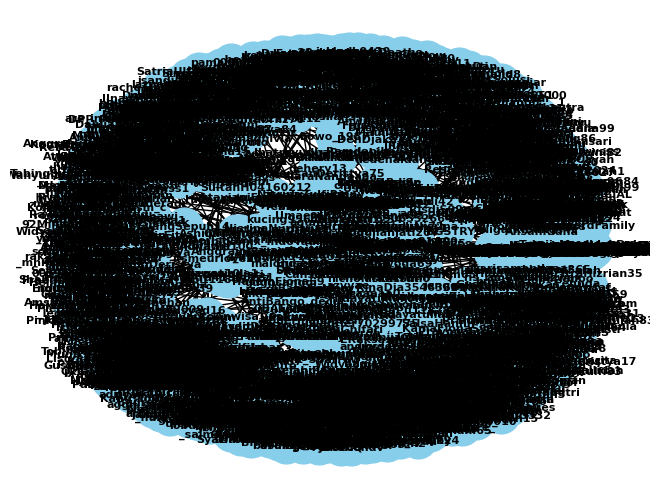

In [19]:
# Create TwitterGraph instance
anies_graph = TwitterGraph(df_anies)

# Calculate feature_indegree(for generating node)
anies_graph.calculate_feature_indegree()

# Drop unused feeature
anies_graph.drop_unused_features()

# Extract mention_list from mention on text
anies_graph.extract_mention_list_from_text()

# Generate new random node
new_data = anies_graph.generate_new_data()

# Add new node to DataFrame
anies_graph.add_new_data_to_dataframe(new_data)

# Add nodes and edges
anies_graph.add_nodes_and_edges()

# Collect centrality measurement
anies_centrality = anies_graph.calculate_centralities()

# Visualize the graph
anies_graph.visualize_graph()

##Centrality Measurement

In [20]:
anies_graph.display_centrality_measurement(anies_centrality)

,Node,Betweenness Centrality,Raw Betweenness Centrality
0,aniesbaswedan,0.000064,322
1,f_wandal3,0.000020,98
2,bro_munozz,0.000010,50
3,viverepericls,0.000008,41
4,muchlis_ar,0.000007,37
5,MaxJo777,0.000006,30
6,ironmxn6,0.000006,29
7,Tjel0up,0.000005,25
8,everyoneislier,0.000005,25
9,renita_hartini,0.000004,18


,Node,In-Degree Centrality,Raw In-Degree Centrality
0,aniesbaswedan,0.124442,279
1,Reiza_Patters,0.045049,101
2,Arie_Kriting,0.033006,74
3,rihandaulah,0.018287,41
4,muchlis_ar,0.016503,37
5,tempodotco,0.014273,32
6,imanlagi,0.014273,32
7,awemany,0.014273,32
8,NOTASLIMBOY,0.013381,30
9,ironmxn6,0.012935,29


,Node,Out-Degree Centrality,Raw Out-Degree Centrality
0,f_wandal3,0.005798,13
1,YayiekY,0.005798,13
2,gatau_puyeng,0.005352,12
3,muhidweet,0.004906,11
4,itsmeurlove16,0.004906,11
5,maryusu76023636,0.004906,11
6,irvanasir,0.004906,11
7,kawitah79,0.004906,11
8,Aliensa10,0.004460,10
9,rahmawatiode1,0.004460,10


,Node,Degree Centrality,Raw Degree Centrality
0,aniesbaswedan,0.124888,280
1,Reiza_Patters,0.045049,101
2,Arie_Kriting,0.033006,74
3,rihandaulah,0.018287,41
4,muchlis_ar,0.016949,38
5,tempodotco,0.014273,32
6,imanlagi,0.014273,32
7,awemany,0.014273,32
8,ironmxn6,0.013381,30
9,NOTASLIMBOY,0.013381,30


,Node,Closeness Centrality
0,aniesbaswedan,0.126356
1,kojekrapbetawi,0.067538
2,Reiza_Patters,0.045150
3,Arie_Kriting,0.033760
4,rihandaulah,0.018287
5,tvOneNews,0.017778
6,imanlagi,0.017445
7,muchlis_ar,0.016503
8,Hasbil_Lbs,0.014874
9,awemany,0.014273


,Node,Eigenvector Centrality
0,kumparan,0.652671
1,viverepericls,0.403373
2,fmyvfnkoig,0.403373
3,S4triaBaj4,0.249298
4,udahdebut,0.249298
5,akun_0987654321,0.249298
6,ImAShyPerson820,0.249298
7,VIVAcoid,0.000566
8,strike_bravo_b,0.000509
9,alextham878,0.000283


#Prabowo dataset


In [22]:
# read dataset
df_prabowo = pd.read_csv("/content/prabowo.csv", sep = ';')
print(len(df_prabowo))

1500


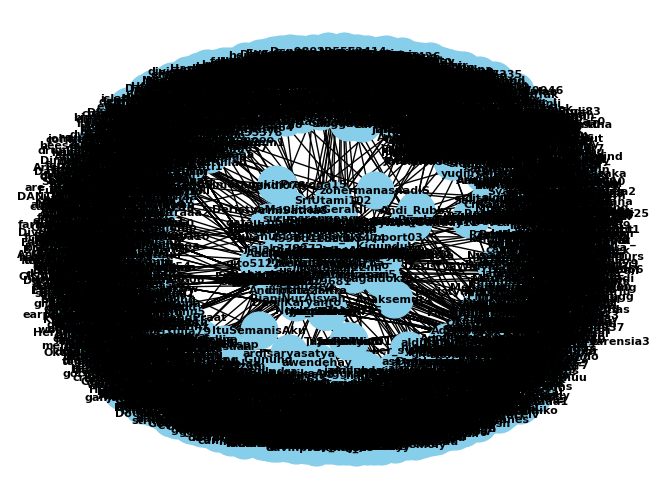

In [23]:
# Create TwitterGraph instance
prabowo_graph = TwitterGraph(df_prabowo)

# Calculate feature_indegree(for generating node)
prabowo_graph.calculate_feature_indegree()

# Drop unused feeature
prabowo_graph.drop_unused_features()

# Extract mention_list from mention on text
prabowo_graph.extract_mention_list_from_text()

# Generate new random node
new_data = prabowo_graph.generate_new_data()

# Add new node to DataFrame
prabowo_graph.add_new_data_to_dataframe(new_data)

# Add nodes and edges
prabowo_graph.add_nodes_and_edges()

# Collect centrality measurement
prabowo_centrality = prabowo_graph.calculate_centralities()

# Visualize the graph
prabowo_graph.visualize_graph()

##Centrality Measurement

In [24]:
prabowo_graph.display_centrality_measurement(prabowo_centrality)

,Node,Betweenness Centrality,Raw Betweenness Centrality
0,gusniindera,3.247960e-05,221
1,hanny23ae,1.440272e-05,98
2,13babpanda,3.674162e-06,25
3,grupchavez,2.645397e-06,18
4,Rakha_boumi,1.175732e-06,8
5,fabianjrit,7.348325e-07,5
6,Michojo2,5.878660e-07,4
7,muhammadsyakur2,5.878660e-07,4
8,rendi078,5.878660e-07,4
9,panjisapp,4.408995e-07,3


,Node,In-Degree Centrality,Raw In-Degree Centrality
0,bangbonny_,0.064009,167
1,prabowo,0.022231,58
2,geloraco,0.015332,40
3,gibran_tweet,0.011882,31
4,Gerindra,0.009966,26
5,bengkeldodo,0.007282,19
6,PartaiSocmed,0.005749,15
7,tvOneNews,0.005749,15
8,ridwankamil,0.004983,13
9,ganjarpranowo,0.004983,13


,Node,Out-Degree Centrality,Raw Out-Degree Centrality
0,gusniindera,0.006516,17
1,guitar0512mi,0.006133,16
2,hanny23ae,0.005366,14
3,grupchavez,0.005366,14
4,AntoniCleo,0.005366,14
5,ekanzoy,0.004983,13
6,harasjoman,0.004983,13
7,gatau_puyeng,0.004599,12
8,LisWidowati1,0.004216,11
9,meow_leader2,0.003833,10


,Node,Degree Centrality,Raw Degree Centrality
0,bangbonny_,0.064009,167
1,prabowo,0.022231,58
2,geloraco,0.015332,40
3,gibran_tweet,0.011882,31
4,gusniindera,0.011499,30
5,Gerindra,0.009966,26
6,hanny23ae,0.008049,21
7,bengkeldodo,0.007282,19
8,guitar0512mi,0.006133,16
9,grupchavez,0.006133,16


,Node,Closeness Centrality
0,bangbonny_,0.064009
1,prabowo,0.024726
2,geloraco,0.015332
3,gibran_tweet,0.014355
4,Gerindra,0.012949
5,ganjarpranowo,0.008785
6,aniesbaswedan,0.008279
7,bengkeldodo,0.007301
8,PartaiSocmed,0.005749
9,tvOneNews,0.005749


,Node,Eigenvector Centrality
0,prabowo,0.365236
1,gibran_tweet,0.365201
2,PDI_Perjuangan,0.365158
3,psi_id,0.365131
4,SayurLodehBTW2,0.365110
5,rinichan02,0.365110
6,SOERYAW4DI,0.365110
7,Rakha_boumi,0.182555
8,tunnov,0.182555
9,Gerindra,0.000104


#Ganjar dataset


In [25]:
# read dataset
df_ganjar = pd.read_csv("/content/ganjar.csv", sep = ';')
print(len(df_ganjar))

1506


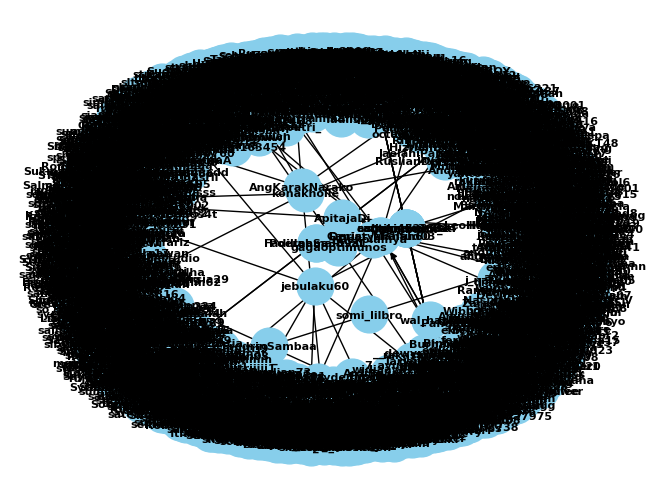

In [26]:
# Create TwitterGraph instance
ganjar_graph = TwitterGraph(df_ganjar)

# Calculate feature_indegree(for generating node)
ganjar_graph.calculate_feature_indegree()

# Drop unused feeature
ganjar_graph.drop_unused_features()

# Extract mention_list from mention on text
ganjar_graph.extract_mention_list_from_text()

# Generate new random node
new_data = ganjar_graph.generate_new_data()

# Add new node to DataFrame
ganjar_graph.add_new_data_to_dataframe(new_data)

# Add nodes and edges
ganjar_graph.add_nodes_and_edges()

# Collect centrality measurement
ganjar_centrality = ganjar_graph.calculate_centralities()

# Visualize the graph
ganjar_graph.visualize_graph()

##Centrality Measurement

In [27]:
ganjar_graph.display_centrality_measurement(ganjar_centrality)

,Node,Betweenness Centrality,Raw Betweenness Centrality
0,Ganjar_Mahfud03,0.000003,25
1,Roberto41359052,0.000000,0
2,rravengger,0.000000,0
3,ginasabrinaaaa,0.000000,0
4,silber_rain,0.000000,0
5,BungacitrCitra,0.000000,0
6,SIITS2013,0.000000,0
7,Dekolainya,0.000000,0
8,Syarman59,0.000000,0
9,yoansptiani1,0.000000,0


,Node,In-Degree Centrality,Raw In-Degree Centrality
0,ganjarpranowo,0.006268,17
1,okezonenews,0.003687,10
2,Nikmatul_Sg,0.003687,10
3,SINDOnews,0.002581,7
4,Ganjar_Mahfud,0.002581,7
5,antaranews,0.002212,6
6,sami86pilang,0.002212,6
7,kompascom,0.002212,6
8,lek_brewok,0.001844,5
9,Nduklala2,0.001844,5


,Node,Out-Degree Centrality,Raw Out-Degree Centrality
0,Ganjar_Mahfud03,0.004794,13
1,jebulaku60,0.002581,7
2,AngKarakNarako,0.001844,5
3,konakholle,0.001475,4
4,TaryokoL,0.001106,3
5,dvtamhrn234,0.000737,2
6,strongerun82,0.000737,2
7,pagi452253,0.000737,2
8,HFitriana6,0.000737,2
9,wal_hasbi,0.000737,2


,Node,Degree Centrality,Raw Degree Centrality
0,ganjarpranowo,0.006268,17
1,Ganjar_Mahfud03,0.005531,15
2,okezonenews,0.003687,10
3,Nikmatul_Sg,0.003687,10
4,Ganjar_Mahfud,0.002581,7
5,SINDOnews,0.002581,7
6,jebulaku60,0.002581,7
7,kompascom,0.002212,6
8,antaranews,0.002212,6
9,sami86pilang,0.002212,6


,Node,Closeness Centrality
0,ganjarpranowo,0.006268
1,okezonenews,0.003687
2,Nikmatul_Sg,0.003687
3,SINDOnews,0.002581
4,Ganjar_Mahfud,0.002581
5,kompascom,0.002212
6,sami86pilang,0.002212
7,antaranews,0.002212
8,lek_brewok,0.001844
9,Nduklala2,0.001844


,Node,Eigenvector Centrality
0,Fahrihamzah,0.279192
1,adearmando61,0.277028
2,mangunsong63,0.277028
3,Siantar72,0.277028
4,Maruahalsiahaa2,0.277028
5,DedynurPalakka,0.277028
6,BANGSAygSUJUD,0.277028
7,alextham878,0.277028
8,KadrunMustDie,0.277028
9,PaimoMontok,0.277028


#All dataset


In [28]:
# read dataset
df_all = pd.concat([anies_graph.df, prabowo_graph.df, ganjar_graph.df])
print(len(df_all))

5729


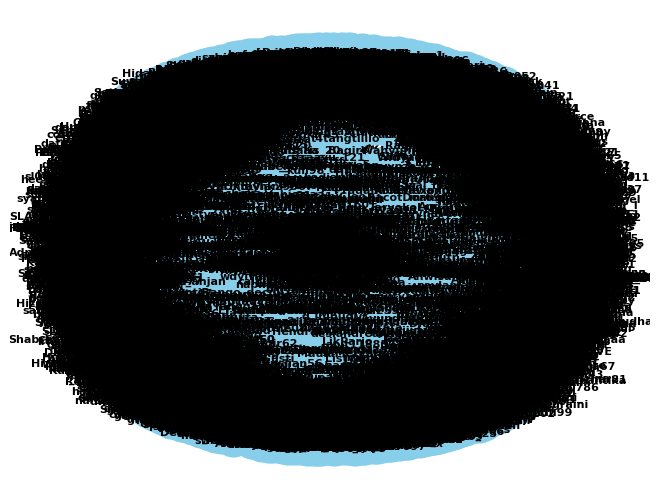

In [29]:
# Create TwitterGraph instance
all_graph = TwitterGraph(df_all)

# Calculate feature_indegree(for generating node)
all_graph.calculate_feature_indegree()

# Drop unused feeature
all_graph.drop_unused_features()

# Extract mention_list from mention on text
all_graph.extract_mention_list_from_text()

# Generate new random node
new_data = all_graph.generate_new_data()

# Add new node to DataFrame
all_graph.add_new_data_to_dataframe(new_data)

# Add nodes and edges
all_graph.add_nodes_and_edges()

# Collect centrality measurement
all_centrality = all_graph.calculate_centralities()

# Visualize the graph
all_graph.visualize_graph()

##Centrality Measurement

In [30]:
all_graph.display_centrality_measurement(all_centrality)

,Node,Betweenness Centrality,Raw Betweenness Centrality
0,aniesbaswedan,7.270292e-06,365
1,gusniindera,4.660954e-06,234
2,hanny23ae,2.091454e-06,105
3,f_wandal3,1.952024e-06,98
4,bro_munozz,9.959304e-07,50
5,ZoneVenomWar,8.764188e-07,44
6,viverepericls,8.166630e-07,41
7,muchlis_ar,7.369885e-07,37
8,MaxJo777,5.975583e-07,30
9,ironmxn6,5.776396e-07,29


,Node,In-Degree Centrality,Raw In-Degree Centrality
0,aniesbaswedan,0.041208,292
1,bangbonny_,0.023568,167
2,Reiza_Patters,0.014253,101
3,Arie_Kriting,0.010866,77
4,prabowo,0.008750,62
5,geloraco,0.008750,62
6,rihandaulah,0.005786,41
7,tvOneNews,0.005504,39
8,imanlagi,0.005363,38
9,gibran_tweet,0.005222,37


,Node,Out-Degree Centrality,Raw Out-Degree Centrality
0,gusniindera,0.002399,17
1,guitar0512mi,0.002258,16
2,grupchavez,0.001976,14
3,hanny23ae,0.001976,14
4,ekanzoy,0.001976,14
5,AntoniCleo,0.001976,14
6,Ganjar_Mahfud03,0.001835,13
7,f_wandal3,0.001835,13
8,harasjoman,0.001835,13
9,YayiekY,0.001835,13


,Node,Degree Centrality,Raw Degree Centrality
0,aniesbaswedan,0.041349,293
1,bangbonny_,0.023568,167
2,Reiza_Patters,0.014253,101
3,Arie_Kriting,0.010866,77
4,geloraco,0.008750,62
5,prabowo,0.008750,62
6,rihandaulah,0.005786,41
7,tvOneNews,0.005504,39
8,imanlagi,0.005363,38
9,muchlis_ar,0.005363,38


,Node,Closeness Centrality
0,aniesbaswedan,0.042250
1,bangbonny_,0.023568
2,kojekrapbetawi,0.023310
3,Reiza_Patters,0.014285
4,Arie_Kriting,0.011096
5,prabowo,0.009612
6,geloraco,0.008758
7,tvOneNews,0.007464
8,imanlagi,0.006586
9,gibran_tweet,0.006121


,Node,Eigenvector Centrality
0,kumparan,0.652668
1,viverepericls,0.403371
2,fmyvfnkoig,0.403371
3,S4triaBaj4,0.249297
4,udahdebut,0.249297
5,akun_0987654321,0.249297
6,ImAShyPerson820,0.249297
7,VIVAcoid,0.001269
8,strike_bravo_b,0.001142
9,alextham878,0.000635


#Convert to xlsx

In [31]:
anies_graph.df.to_excel('anies_dataset.xlsx')
prabowo_graph.df.to_excel('prabowo_dataset.xlsx')
ganjar_graph.df.to_excel('ganjar_dataset.xlsx')
df_all.to_excel('all_dataset.xlsx')

convert to xlsx format for gephi visualitation

In [32]:
dataset = [anies_graph.df,prabowo_graph.df,ganjar_graph.df,df_all]
dataset_name = ['anies_edges','prabowo_edges','ganjar_edges','all_edges']

In [33]:
i = 0
for data in dataset:
    expanded_df = data.explode('mention_list')
    edges_df = expanded_df[['username', 'mention_list']].rename(columns={'username': 'source', 'mention_list': 'target'})
    edges_df = edges_df.dropna(subset=['target'])
    edges_df.to_excel(dataset_name[i]+'.xlsx')
    i = i + 1